# LIME to Inspect Image & Text Classification

In [3]:
import torch
import torch.nn.functional as F

from captum.attr import visualization as viz
from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso

import os
import json

In [4]:
from torchvision.models import resnet18
from torchvision.datasets import VOCSegmentation
import torchvision.transforms as T
from captum.attr._core.lime import get_exp_kernel_similarity_function

from PIL import Image
import matplotlib.pyplot as plt

In [5]:
import torch
import torch.nn.functional as F

from captum.attr import visualization as viz
from captum.attr import Lime, LimeBase
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso

import os
import json

In [6]:
resnet = resnet18(pretrained=True)
resnet = resnet.eval()

c:\Users\197796\Anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\197796\Anaconda3\envs\torch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
labels_path = 'imagenet_class_index.json'
with open(labels_path) as json_data:
    idx_to_labels = {idx: label for idx, [_, label] in json.load(json_data).items()}

In [8]:
voc_ds = VOCSegmentation(
    './VOC',
    year='2012',
    image_set='train',
    download=False,
    transform=T.Compose([
        T.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )    
    ]),
    target_transform=T.Lambda(
        lambda p: torch.tensor(p.getdata()).view(1, p.size[1], p.size[0])
    )
)

AttributeError: module 'torch' has no attribute '_six'

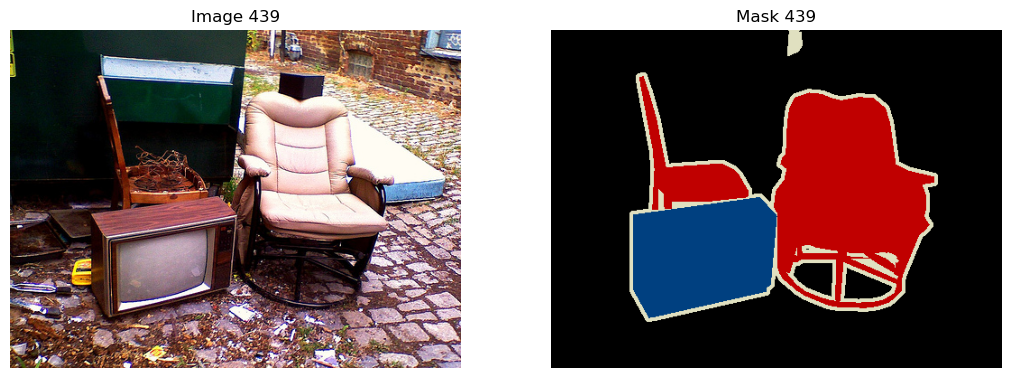

In [ ]:
sample_idx = 439

def show_image(ind): 
    fig, ax = plt.subplots(1, 2, figsize=[6.4 * 2, 4.8])
    for i, (name, source) in enumerate(zip(['Image', 'Mask'], [voc_ds.images, voc_ds.masks])):
        ax[i].imshow(Image.open(source[ind]));
        ax[i].set_title(f"{name} {ind}")
        ax[i].axis('off')

show_image(sample_idx)

In [ ]:
img, seg_mask = voc_ds[sample_idx]  # tensors of shape (channel, hight, width)

outputs = resnet(img.unsqueeze(0))
output_probs = F.softmax(outputs, dim=1).squeeze(0)

In [ ]:
def print_result(probs, topk=1):
    probs, label_indices = torch.topk(probs, topk)
    probs = probs.tolist()
    label_indices = label_indices.tolist()
    for prob, idx in zip(probs, label_indices):
        label = idx_to_labels[str(idx)]
        print(f'{label} ({idx}):', round(prob, 4))
        
print_result(output_probs, topk=5)

television (851): 0.083
screen (782): 0.0741
monitor (664): 0.0619
laptop (620): 0.0421
ashcan (412): 0.03


## Inspect the model prediction with Lime

In [ ]:
seg_ids = sorted(seg_mask.unique().tolist())
print('Segmentation IDs:', seg_ids)

# map segment IDs to feature group IDs
feature_mask = seg_mask.clone()
for i, seg_id in enumerate(seg_ids):
    feature_mask[feature_mask == seg_id] = i
    
print('Feature mask IDs:', feature_mask.unique().tolist())

Segmentation IDs: [0, 9, 20, 255]
Feature mask IDs: [0, 1, 2, 3]


In [ ]:
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)

lr_lime = Lime(
    resnet, 
    interpretable_model=SkLearnLinearRegression(),  # build-in wrapped sklearn Linear Regression
    similarity_func=exp_eucl_distance
)

 Essentially, Lime trains an interpretable surrogate model to simulate the target model's predictions. So, building an appropriate interpretable model is the most critical step in Lime. Fortunately, Captum has provided many most common interpretable models to save the efforts. We will demonstrate the usages of Linear Regression and Linear Lasso. Another important factor is the similarity function. Because Lime aims to explain the local behavior of an example, it will reweight the training samples according to their similarity distances. By default, Captum's Lime uses the exponential kernel on top of the consine distanc

In [ ]:
label_idx = output_probs.argmax().unsqueeze(0)
attrs = lr_lime.attribute(
    img.unsqueeze(0),
    target=label_idx,
    feature_mask=feature_mask.unsqueeze(0),
    n_samples=40,
    perturbations_per_eval=16,
    show_progress=True
).squeeze(0)

print('Attribution range:', attrs.min().item(), 'to', attrs.max().item())

Lime attribution:   0%|          | 0/3 [00:00<?, ?it/s]

Attribution range: -0.34585055708885193 to 2.8088748455047607


Next, we will analyze these groups' influence on the most confident prediction television. Every time we call Lime's attribute function, an interpretable model is trained around the given input, so unlike many other Captum's attribution algorithms, it is strongly recommended to only provide a single example as input (tensors with first dimension or batch size = 1).

 Lime creates the perturbed samples in the form of interpretable representation, i.e., a binary vector indicating the “presence” or “absence” of features

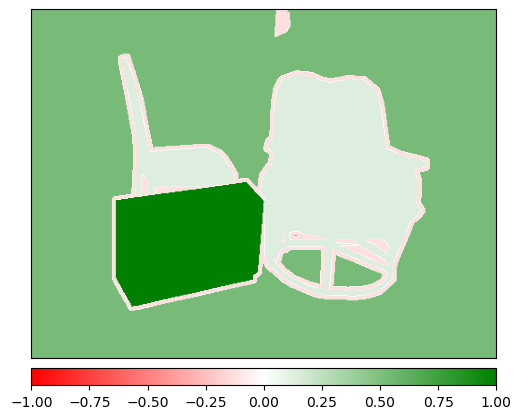

In [ ]:
def show_attr(attr_map):
    viz.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),  # adjust shape to height, width, channels 
        method='heat_map',
        sign='all',
        show_colorbar=True
    )
    
show_attr(attrs)

The result looks decent: the television segment does demonstrate strongest positive correlation with the prediction, while the chairs has relatively trivial impact and the border slightly shows negative contribution.

Lime attribution:   0%|          | 0/1 [00:00<?, ?it/s]

Attribution range: -0.04702622815966606 to 2.5328257083892822


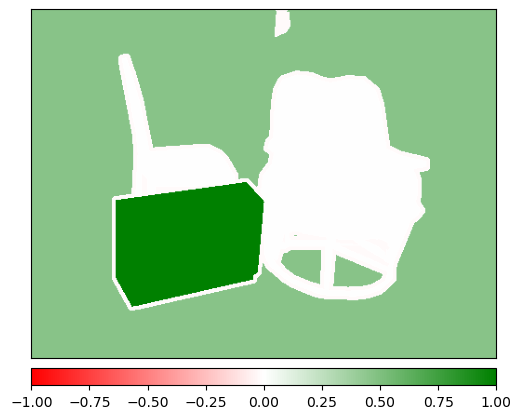

In [ ]:
n_interpret_features = len(seg_ids)

def iter_combinations(*args, **kwargs):
    for i in range(2 ** n_interpret_features):
        yield torch.tensor([int(d) for d in bin(i)[2:].zfill(n_interpret_features)]).unsqueeze(0)
    
lasso_lime = Lime(
    resnet, 
    interpretable_model=SkLearnLasso(alpha=0.08),
    similarity_func=exp_eucl_distance,
    perturb_func=iter_combinations
)

attrs = lasso_lime.attribute(
    img.unsqueeze(0),
    target=label_idx,
    feature_mask=feature_mask.unsqueeze(0),
    n_samples=2 ** n_interpret_features,
    perturbations_per_eval=16,
    show_progress=True
).squeeze(0)

print('Attribution range:', attrs.min().item(), 'to', attrs.max().item())
show_attr(attrs)

As we can see, the new attribution result removes the chairs and border with the help of Lasso.

In [ ]:
alter_label_idx = 765

alter_prob = output_probs[alter_label_idx].item()
print(f'{idx_to_labels[str(alter_label_idx)]} ({alter_label_idx}):', round(alter_prob, 4))

rocking_chair (765): 0.0048


Another interesting question to explore is if the model also recognize the chairs in the image. To answer it, we will use the most related label rocking_chair from ImageNet as the target, whose label index is 765. We can check how confident the model feels about the alternative object.

Lime attribution:   0%|          | 0/1 [00:00<?, ?it/s]

Attribution range: -0.16570615768432617 to 1.4231903553009033


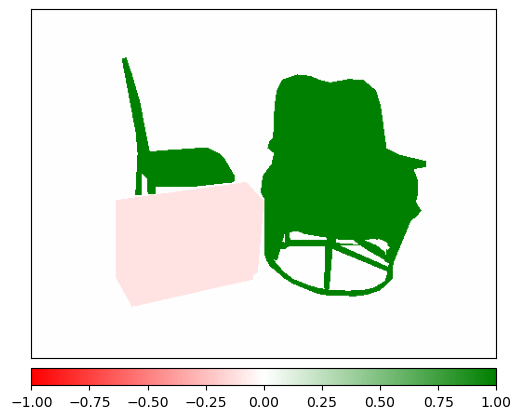

In [ ]:
attrs = lasso_lime.attribute(
    img.unsqueeze(0),
    target=alter_label_idx,
    feature_mask=feature_mask.unsqueeze(0),
    n_samples=2 ** n_interpret_features,
    perturbations_per_eval=16,
    show_progress=True,
    return_input_shape=True,
).squeeze(0)

print('Attribution range:', attrs.min().item(), 'to', attrs.max().item())
show_attr(attrs)

### Understand the sampling process

In [ ]:
SAMPLE_INDEX = 13

pertubed_genertator = iter_combinations()
for _ in range(SAMPLE_INDEX + 1):
    sample_interp_inp = next(pertubed_genertator)
    
print('Perturbed interpretable sample:', sample_interp_inp)

Perturbed interpretable sample: tensor([[1, 1, 0, 1]])


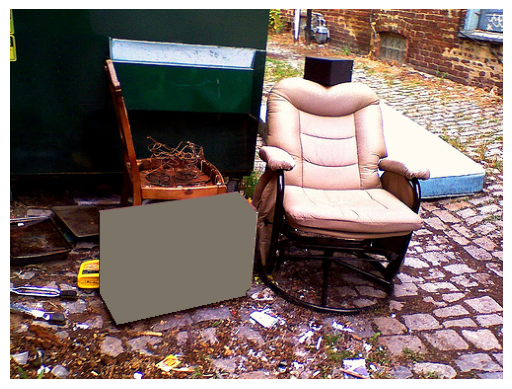

In [ ]:
pertubed_img = lasso_lime.from_interp_rep_transform(
    sample_interp_inp,
    img.unsqueeze(0),
    feature_mask=feature_mask.unsqueeze(0),
    baselines=0
)

# invert the normalization for render
invert_norm = T.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

plt.imshow(invert_norm(pertubed_img).squeeze(0).permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()

In [ ]:
perturbed_outputs = resnet(pertubed_img).squeeze(0).detach()
sample_label = perturbed_outputs[label_idx.item()]
print('Label of the perturbed sample as Television:', sample_label)

print('\nProbabilities of the perturbed image')
perturbed_output_probs = F.softmax(perturbed_outputs, dim=0)
print_result(perturbed_output_probs, topk=5)
print(f'\ntelevision ({label_idx.item()}):', perturbed_output_probs[label_idx].item())

Label of the perturbed sample as Television: tensor(3.2104)

Probabilities of the perturbed image
jigsaw_puzzle (611): 0.094
chest (492): 0.0377
laptop (620): 0.0338
birdhouse (448): 0.0328
ashcan (412): 0.0315

television (851): 0.006506193429231644


In [ ]:
sample_similarity = exp_eucl_distance(img.unsqueeze(0), pertubed_img, None)
print('Sample similarity:', sample_similarity)

Sample similarity: 0.9705053132290518


Note the calculation is based on the input space instead of the interpretable space. This step is simply passing the two image tensors into the given similarity_func argument which is the exponential kernel of euclidean distance in our case.

# Text Classification

In [ ]:
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchtext.datasets import AG_NEWS
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import Vocab

from collections import Counter

from IPython.core.display import HTML, display 

ModuleNotFoundError: No module named 'torchtext'